In [1]:
#import data_preprocess_functions as dp_f
import argparse, configparser
import re
import ast
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec
import os

from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

from tensorflow.keras.utils import to_categorical

from tensorflow.keras import Model
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
import makeplots as mkplots

def find(str_jets,df):
    n=0
    for i in df['origin']==str_jets:
        if i==True:
            n+=1
    return n
    
    

def composition_plot(df,directory,signal,analysis,channel,PreselectionCuts):
    x=np.array([])
    samples=list(set(df['origin']))
    for var in samples:
        x=np.append(x,find(var,df))

    plt.figure(1,figsize=(18,6))
    plt.bar(samples,x)
    #plt.text(3, 80, analysis+' '+channel , fontsize=12,horizontalalignment='center',verticalalignment='center')
#    plt.suptitle(analysis+' '+channel+' composition')
    plt.yscale('log')
    plt.savefig(directory+'/'+signal+'_'+analysis+'_'+channel+'_'+PreselectionCuts+'_composition.pdf')
#    plt.show()
    return x,samples
    

Using TensorFlow backend.


In [3]:
analysis='merged'
channel='ggF'
PreselectionCuts=''
samples=['Zjets','Wjets','stop','Diboson','ttbar','Radion','VBFRSG','RSG','VBFRadion','VBFHVTWZ']

### Reading from config file
config = configparser.ConfigParser()
config.read('MyConfig.txt')
inputFiles = ast.literal_eval(config.get('config', 'inputFiles'))
dataType = ast.literal_eval(config.get('config', 'dataType'))
rootBranchSubSample = ast.literal_eval(config.get('config', 'rootBranchSubSample'))
dfPath = config.get('config', 'dfPath')

#list of files under dfPath
files=os.listdir(dfPath)
#InputFeaturesResolved for 'resolved' analysis --> make it dyn
if analysis == 'merged':
    dataVariables = ast.literal_eval(config.get('config', 'InputFeaturesMerged'))
elif analysis == 'resolved':
    dataVariables = ast.literal_eval(config.get('config', 'InputFeaturesResolved'))

#DSID must not be included in the configfile! #
#It's important the order here ! 
dataVariables.append('isSignal')
dataVariables.append('origin')
dfPath = config.get('config', 'dfPath')

In [4]:
dataVariables,samples

(['lep1_m',
  'lep1_pt',
  'lep1_eta',
  'lep1_phi',
  'lep2_m',
  'lep2_pt',
  'lep2_eta',
  'lep2_phi',
  'fatjet_m',
  'fatjet_pt',
  'fatjet_eta',
  'fatjet_phi',
  'fatjet_D2',
  'NJets',
  'Zcand_m',
  'Zcand_pt',
  'mass',
  'isSignal',
  'origin'],
 ['Zjets',
  'Wjets',
  'stop',
  'Diboson',
  'ttbar',
  'Radion',
  'VBFRSG',
  'RSG',
  'VBFRadion',
  'VBFHVTWZ'])

In [5]:
#import pickle as pickle
#with open(dfPath+'MixData_PD_'+analysis+'_'+channel+'_p4.pkl', "rb") as fh:
#      mixed_data = pickle.load(fh)

In [6]:
data=pd.read_pickle(dfPath+'MixData_PD_'+analysis+'_'+channel+'__p4.pkl')
data=data[dataVariables]

In [39]:
def LoadData(dfPath,file_name):
    dfInput = dfPath + file_name
    df = pd.read_pickle(dfInput)
    columns=df.columns
    X = df.values
    y = np.array(df['isSignal'])
    return X, y, columns, df

In [38]:
#select signal
#import os


for i in range(1,6):
    signal=samples[-i]

    outdir=dfPath+'outDF/'+str(signal)+'_'+analysis+'_'+channel+'_'+PreselectionCuts+'/'
    if not os.path.isdir(outdir):
        os.mkdir(outdir)
        print('created: ',outdir)
    else:
        print(outdir,'already exists')
        
#    print(signal)
    training_samples=samples[:5]
    training_samples.append(signal)
    print(training_samples)
    q_string=''
    for k in range(0,len(training_samples)):
        q_string+='origin.str.match("'+training_samples[k]+'") or '
    q_string=q_string[:-4]
#    print(q_string)
    data_set=data.query(q_string, engine='python')
#    data_set=data_set.drop('origin',1)
    data_set.to_pickle(outdir+ signal+'Data_' + analysis + '_' + channel + '_' + PreselectionCuts+'_p4.pkl')
    print(outdir+ signal+'Data_' + analysis + '_' + channel + '_' + PreselectionCuts+'_p4.pkl','saved')
    #directory='outDF/'+signal+ '_' + analysis+ '_' + channel+ '_' + PreselectionCuts+'/'
    

/nfs/kloe/einstein4/HDBS/NN_InputDataFrames/TCC_DataFrames/outDF/VBFHVTWZ_merged_ggF_/ already exists
['Zjets', 'Wjets', 'stop', 'Diboson', 'ttbar', 'VBFHVTWZ']
/nfs/kloe/einstein4/HDBS/NN_InputDataFrames/TCC_DataFrames/outDF/VBFHVTWZ_merged_ggF_/VBFHVTWZData_merged_ggF__p4.pkl saved
/nfs/kloe/einstein4/HDBS/NN_InputDataFrames/TCC_DataFrames/outDF/VBFRadion_merged_ggF_/ already exists
['Zjets', 'Wjets', 'stop', 'Diboson', 'ttbar', 'VBFRadion']
/nfs/kloe/einstein4/HDBS/NN_InputDataFrames/TCC_DataFrames/outDF/VBFRadion_merged_ggF_/VBFRadionData_merged_ggF__p4.pkl saved
/nfs/kloe/einstein4/HDBS/NN_InputDataFrames/TCC_DataFrames/outDF/RSG_merged_ggF_/ already exists
['Zjets', 'Wjets', 'stop', 'Diboson', 'ttbar', 'RSG']
/nfs/kloe/einstein4/HDBS/NN_InputDataFrames/TCC_DataFrames/outDF/RSG_merged_ggF_/RSGData_merged_ggF__p4.pkl saved
/nfs/kloe/einstein4/HDBS/NN_InputDataFrames/TCC_DataFrames/outDF/VBFRSG_merged_ggF_/ already exists
['Zjets', 'Wjets', 'stop', 'Diboson', 'ttbar', 'VBFRSG']
/nfs

/nfs/kloe/einstein4/HDBS/NN_InputDataFrames/TCC_DataFrames/outDF/VBFHVTWZ_merged_ggF_/ already exists
(array([4.13720e+04, 1.38900e+03, 1.47000e+02, 9.60000e+01, 4.28101e+05,
       5.05900e+04]), ['Diboson', 'ttbar', 'Wjets', 'stop', 'Zjets', 'VBFHVTWZ'])
train:  1.0859461066766088e-15 1.000000000000931
test:  3.514026074731974e-05 1.0036363468441143
/nfs/kloe/einstein4/HDBS/NN_InputDataFrames/TCC_DataFrames/outDF/VBFRadion_merged_ggF_/ already exists
(array([4.13720e+04, 1.38900e+03, 1.47000e+02, 9.60000e+01, 6.57720e+04,
       4.28101e+05]), ['Diboson', 'ttbar', 'Wjets', 'stop', 'VBFRadion', 'Zjets'])
train:  3.4837113231105595e-16 0.9999999999999828
test:  -0.00038065536151042227 0.9886645305875095
/nfs/kloe/einstein4/HDBS/NN_InputDataFrames/TCC_DataFrames/outDF/RSG_merged_ggF_/ already exists
(array([4.13720e+04, 1.38900e+03, 8.44690e+04, 1.47000e+02, 9.60000e+01,
       4.28101e+05]), ['Diboson', 'ttbar', 'RSG', 'Wjets', 'stop', 'Zjets'])
train:  -8.898014652596385e-16 0.9999999

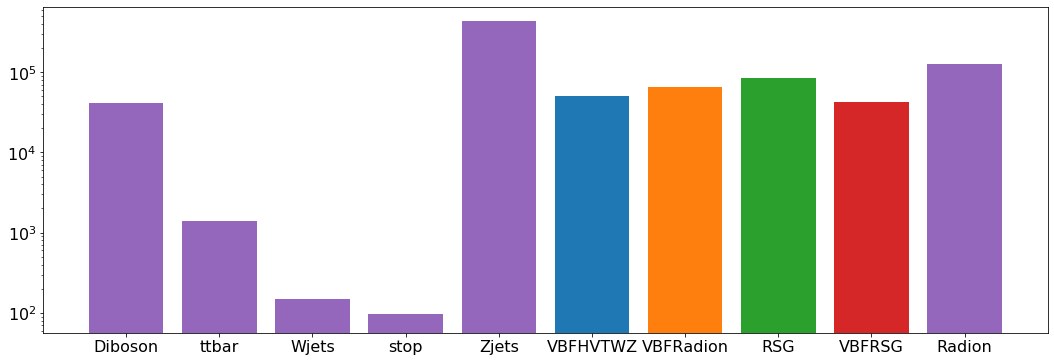

In [43]:
for i in range(1,6):
    
    signal=samples[-i]
    outdir=dfPath+'outDF/'+str(signal)+'_'+analysis+'_'+channel+'_'+PreselectionCuts+'/'
    if not os.path.isdir(outdir):
        os.mkdir(outdir)
        print('created: ',outdir)
    else:
        print(outdir,'already exists')

    signal=samples[-i]

    file_name=signal+'Data_' + analysis + '_' + channel + '_' + PreselectionCuts+'_p4.pkl'
    X,y,columns,df=LoadData(outdir, file_name)
    composition=composition_plot(df, outdir, signal, analysis, channel, PreselectionCuts)
    print(composition)

    
    test_frac=0.2
    #X, y = shuffle(X, y, random_state=0)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_frac)


    #masses=np.sort(np.array(list(set(list(X_train[:,-3].flatten())))))
    #print(masses)

    #scaler_train = RobustScaler().fit(X_train[:,:-1])
    scaler_train = StandardScaler().fit(X_train[:,:-2])
    X_train_scaled=np.array(scaler_train.transform(X_train[:,:-2]), dtype=object)
    X_test_scaled=np.array(scaler_train.transform(X_test[:,:-2]), dtype=object)

    y_train_cat=to_categorical(y_train)
    y_test_cat=to_categorical(y_test)

    print('train: ',X_train_scaled.mean(),X_train_scaled.std())
    print('test: ',X_test_scaled.mean(),X_test_scaled.std())

    X_train_scaled_m=np.insert(X_train_scaled, X_train_scaled.shape[1], X_train[:,-2], axis=1)
    X_test_scaled_m=np.insert(X_test_scaled, X_test_scaled.shape[1], X_test[:,-2], axis=1)


    np.savetxt(outdir+"X_train.csv",X_train,delimiter=',',fmt='%s')
    np.savetxt(outdir+"X_train_scaled.csv",X_train_scaled,delimiter=',')
    np.savetxt(outdir+"X_train_scaled_m.csv",X_train_scaled_m,delimiter=',',fmt='%s')
    np.savetxt(outdir+"X_test.csv",X_test,delimiter=',',fmt='%s')
    np.savetxt(outdir+"X_test_scaled.csv",X_test_scaled,delimiter=',')
    np.savetxt(outdir+"X_test_scaled_m.csv",X_test_scaled_m,delimiter=',',fmt='%s')
    np.savetxt(outdir+"y_train.csv",y_train,delimiter=',')
    np.savetxt(outdir+"y_train_cat.csv",y_train_cat,delimiter=',')
    np.savetxt(outdir+"y_test.csv",y_test,delimiter=',')
    np.savetxt(outdir+"y_test_cat.csv",y_test_cat,delimiter=',')

In [45]:
X_train_scaled_Radion=np.genfromtxt('/nfs/kloe/einstein4/HDBS/NN_InputDataFrames/TCC_DataFrames/outDF/Radion_merged_ggF_/X_train_scaled.csv', delimiter=',')
X_test_scaled_Radion=np.genfromtxt('/nfs/kloe/einstein4/HDBS/NN_InputDataFrames/TCC_DataFrames/outDF/Radion_merged_ggF_/X_test_scaled.csv', delimiter=',')

In [47]:
X_train_scaled_Radion==X_train_scaled

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

In [48]:
X_train_scaled_VBFRSG=np.genfromtxt('/nfs/kloe/einstein4/HDBS/NN_InputDataFrames/TCC_DataFrames/outDF/VBFRSG_merged_ggF_/X_train_scaled.csv', delimiter=',')
X_test_scaled_VBFRSG=np.genfromtxt('/nfs/kloe/einstein4/HDBS/NN_InputDataFrames/TCC_DataFrames/outDF/VBFRSG_merged_ggF_/X_test_scaled.csv', delimiter=',')

In [49]:
X_train_scaled_VBFRSG.mean(),X_train_scaled_VBFRSG.std()


(4.976862437430879e-17, 1.0000000000000628)

In [50]:
X_test_scaled_VBFRSG.mean(),X_test_scaled_VBFRSG.std()

(-0.0006259631466625452, 1.4699361590611484)

1.0
9800
0.01641948087633115
[0.3   0.28  0.1   0.3   0.015 0.005]
[2940, 2744, 980, 2940, 147, 49]


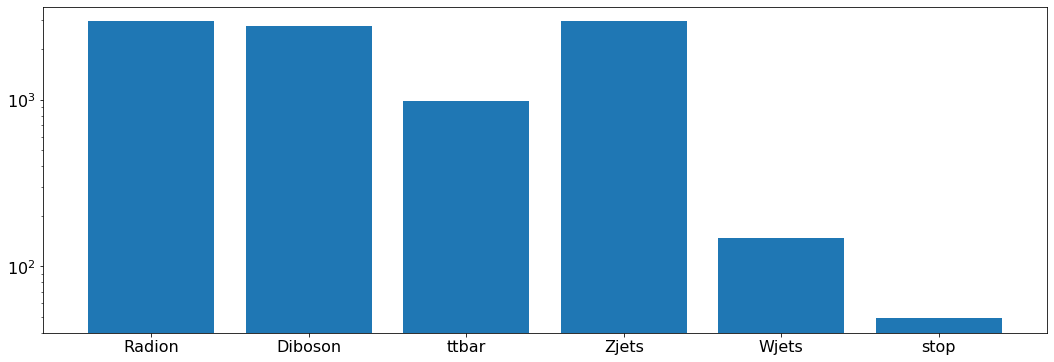

In [217]:
q_v=[0.3,0.28,0.10,0.3,0.015]
q_v.append(1-sum(q_v))
q=np.array(q_v)
print(np.sum(q))


N_entries=sum(composition[0])
p=np.array(composition[0]/N_entries)

N_v=p[np.argsort(p)]/q[np.argsort(p)]
N_v=N_v[np.argsort(N_v)]
N_prime_tot=int(N_entries*N_v[0])
composition_q=[int(q[n]*N_prime_tot) for n in range(0,len(p))]

q=np.array(composition_q)/N_prime_tot
if (composition_q<=N_entries).all():
#    print('True')
    print(N_prime_tot)
    print(N_prime_tot/N_entries)
    print(q)
    print(composition_q)

training_samples=list(set(df['origin']))
reweighted_df=pd.concat(df.query('origin.str.match("'+training_samples[k]+'")').sample(frac=1)[:composition_q[k]] for k in range(0,len(training_samples)))
reweighted_df_composition=composition_plot(reweighted_df)
#reweighted_df.to_pickle(outdir+ signal + 'Data_' + analysis + '_' + channel + '_' + PreselectionCuts+'_reweighted_dataset.pkl')

In [338]:
columns

Index(['lep1_m', 'lep1_pt', 'lep1_eta', 'lep1_phi', 'lep2_m', 'lep2_pt',
       'lep2_eta', 'lep2_phi', 'fatjet_m', 'fatjet_pt', 'fatjet_eta',
       'fatjet_phi', 'fatjet_D2', 'NJets', 'Zcand_m', 'Zcand_pt', 'mass',
       'isSignal', 'origin'],
      dtype='object')